# GRIDtools Example 1: Zonal module

Perform the necessary imports, GRIDtools install of v0.1.0 may still require you to set up an environment with the necessary dependencies.

In [12]:
import pynhd
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np
from chmdata.thredds import GridMet, BBox
import GRIDtools as gt

Let's create a Geopandas GeoDataFrame of a couple of points within the Lolo Watershed in western Montana. Also, a "name" column is added to provide a unique ID to each point.

In [2]:
# Create geopandas.GeoDataFrame of some points we want to delineate upstream catchments for
pour_pnt = gpd.GeoDataFrame(
    {
        "name": ["Lolo_Catchment", "Bear_Creek_Catchment"]
    },
    geometry=[Point(-114.133170, 46.748808),
              Point(-114.324042, 46.766956)],
    crs=4326
)

Use GRIDtools delineate watershed function with the GeoDataFrame as input to get the drainage areas upstream of the points.

In [3]:
# Use delineate_watershed function to get polygon's of the contributing drainage area upstream of each point in GeoDataFrame
result = gt.delineate_watershed(pour_pnt)

In [4]:
# view table
result

,req_idx,catchmentID,geometry,Area_sqKm,name,direction,upstream,gnis_name,comid,reachcode,intersection_point
0,1,NaN,"POLYGON ((-114.35519 46.82845, -114.35519 46.8...",28.379194,Bear_Creek_Catchment,up,True,Bear Creek,24321310,17010205001011,"[-114.32473199573879, 46.76647114978662]"
1,0,NaN,"POLYGON ((-114.65629 46.739, -114.65629 46.739...",653.531430,Lolo_Catchment,up,True,Lolo Creek,24319270,17010205000088,"[-114.12979611165137, 46.747740712007136]"


You can see that the result returns another Geopandas GeoDataFrame that contains POLYGON geometries for the upstream drainage areas. The original uniqe ID (in this case the "name" column) is retained and additional attributes are returned including the Area in square Kilometers, the GNIS_name of the NHD segment that each point intersected, as well as its comid and reachcode. The catchmentID is NaN because it is a custom delineation so it does not conform to a known HUC. The intersection point is the flow direction trace intersection point from the original input point and where it intersected an NHD stream segment.

We can use Geopandas to visualize the output POLYGONs.

<Axes: >

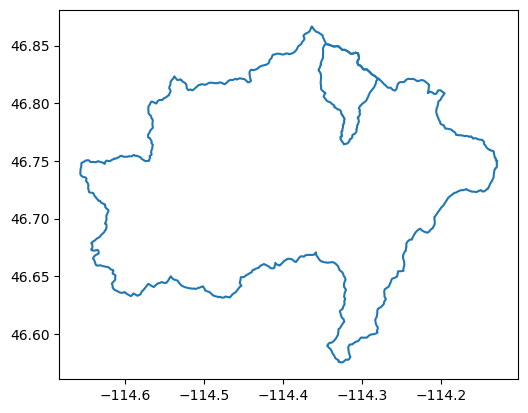

In [5]:
# plot watershed boundaries
result.boundary.plot()

## Get GridMET Precipitation Data

Next we will use DNRC's chmdata package to get some precipitation data for the delineated watersheds.

In [6]:
# Use chmdata to get GridMET precipitation data for the area of interest
# Create the bbox
bnds = result.total_bounds
bbox = BBox(bnds[0]-0.5, bnds[2]+0.5, bnds[3]+0.5, bnds[1]-0.5)
gmet = GridMet(variable='pr', start='2016-01-01', end='2024-12-01', bbox=bbox)
prcp = gmet.subset_nc(return_array=True)
# write the crs so rioxarray recognizes it
prcp = prcp.rio.write_crs(4326, inplace=True)

This returns an xarray Dataset for the given bounding box. We can use Matplotlib to visulaize the grided data (in this case the total sum for the period requested 2016-01-01 to 2024-12-01).

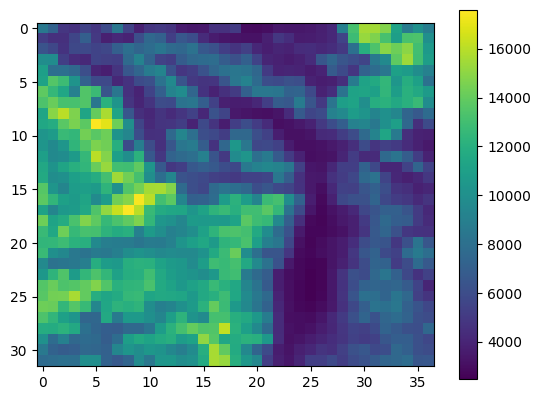

In [7]:
# view cumulative precip over the time period
plt.imshow(prcp.precipitation_amount.sum(dim='time'))
plt.colorbar()

## Area Weighted Volumes from Depth raster datasets (e.g., precipitation, snow water equivalent, etc.)

Next we can use the precipitation_amount DataArray as input to the GRIDtools grid_area_weighted_volume function, along with our geometries of interest (in this case the output of the delineate watershed function), and then a specification of which column in the input GeoDataFrame we would like to use as location ID's in the resulting dataset.

The 'data_scale' argument here converts the precipitation data that is millimeters to meters.

In [8]:
vol = gt.grid_area_weighted_volume(prcp.precipitation_amount , result, geom_id_col='name', data_scale=1000)

Viewing the result we see that the output is another xarray Dataset that contains dimensions of time and location (polygons), there is a coordinate variable denoting the location ID, also a coordinate variable that contains the input polygon area in square kilometers.

The data variable of the output is the volume of the input depth dataset (in this case precipitation) in cubic meters.

In [9]:
vol

<xarray.Dataset> Size: 78kB
Dimensions:   (time: 3258, location: 2)
Coordinates:
  * location  (location) <U20 160B 'Bear_Creek_Catchment' 'Lolo_Catchment'
    area      (location) float64 16B 28.38 653.5
  * time      (time) datetime64[ns] 26kB 2016-01-01 2016-01-02 ... 2024-12-01
Data variables:
    volume    (time, location) float64 52kB 0.0 0.0 0.0 ... 1.501e+03 6.22e+03
Attributes:
    featureType:  timeSeries

## Visualize the Results

C:\Users\CNB968\AppData\Local\Temp\ipykernel_11576\3430974382.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(vol.time.values, vol.volume.sel(location=i).values, marker=None, ls='solid', label=i, alpha=0.6)
C:\Users\CNB968\AppData\Local\Temp\ipykernel_11576\3430974382.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(vol.time.values, vol.volume.sel(location=i).cumsum().values, marker=None, ls='solid', label=i)
C:\Users\CNB968\AppData\Local\Temp\ipykernel_11576\3430974382.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(vol.time.values, vol.volume.sel(location=i).cumsum().values, marker=None, ls='

Text(0, 0.5, 'Annual Total Precip Volume ($m^3$)')

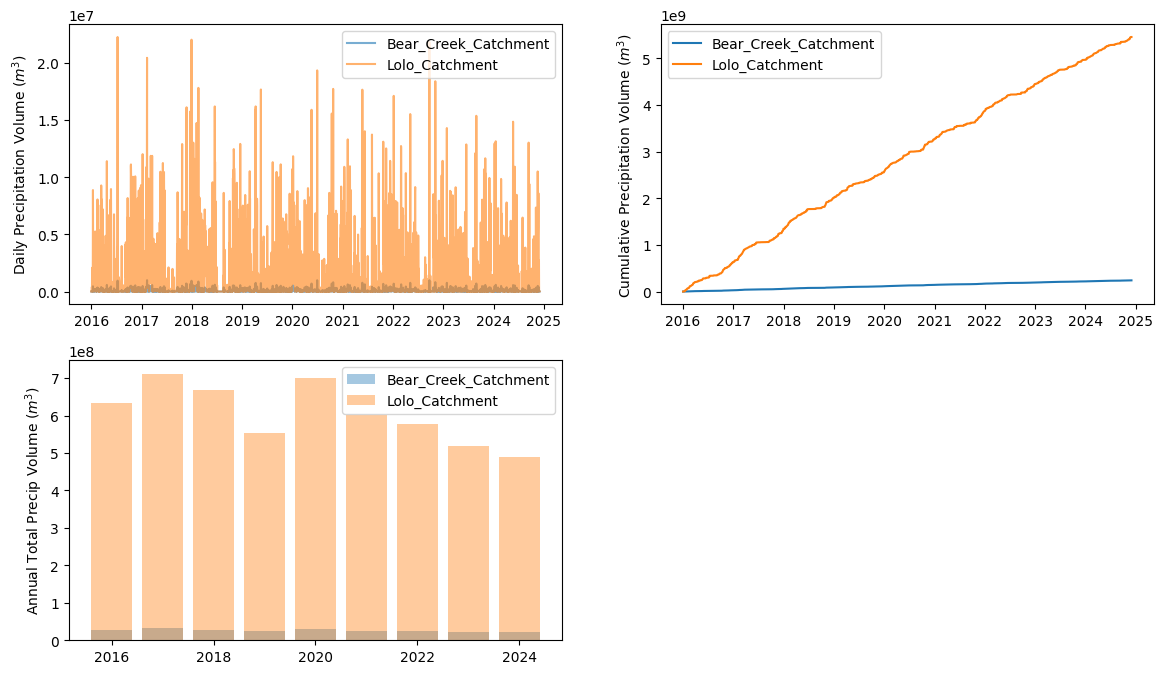

In [11]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
for i in vol.location.values:
    ax.plot_date(vol.time.values, vol.volume.sel(location=i).values, marker=None, ls='solid', label=i, alpha=0.6)
ax.legend()
ax.set_ylabel('Daily Precipitation Volume ($m^3$)')
for i in vol.location.values:
    ax2.plot_date(vol.time.values, vol.volume.sel(location=i).cumsum().values, marker=None, ls='solid', label=i)
ax2.legend()
ax2.set_ylabel('Cumulative Precipitation Volume ($m^3$)')
yr_resamp = vol.resample(time='YE').sum()
for i in vol.location.values:
    ax3.bar(yr_resamp.time.dt.year.values, yr_resamp.volume.sel(location=i).values, label=i, alpha=0.4)
ax3.legend()
ax3.set_ylabel('Annual Total Precip Volume ($m^3$)')

## Get multidimensional zonal statstics with GRIDtools

We can also use the calc_zonal_stats() function in GRIDtools to get zonal statistics the traditional way, where geometries are rasterized and imposed on the gridded dataset. This function is capable of handling some overlapping geometries as well as sub-grid resolution polygons (many rasterize zonal stats methods will not return data for these cases). The calc_zonal_stats() function does only try 2 attempts to rasterize missed features before defaulting to treating the polygons as a point. So, many inset polygons would inevitably get treated as points which may not be desireable. In future versions the behavior of rasterization attempts could be controlled by the user.

In [13]:
zon = gt.calc_zonal_stats(result, prcp, stats=['mean', 'count', pd.Series.mode], output='pandas')

C:\Users\CNB968\AppData\Local\Temp\ipykernel_11576\1008504869.py:1: UserWarning: Not all geometries were returned, 1 geometries were missed during rasterize. Attempting to rasterize missed geometries...
  zon = gt.calc_zonal_stats(result, prcp, stats=['mean', 'count', pd.Series.mode], output='pandas')


When the calc_zonal_stats() method = 'groupby' then the aggregation is handled by pandas. This is the default behavior of the function. The rasterstats method uses the rasterstats package and will require that dependency if used. It also does not currently handle multidimensional data.

Since the groupby method is passed to pandas, this example shows how pandas.Series aggregation or GroupBy functions can be passed as well as string names of statistics. This is the case here to get the 'mode' of the data in each polygon.

In [14]:
zon

precipitation_amount
FID time       stat                      
0   2016-01-01 count                    3
               mean                   0.0
               mode                   0.0
    2016-01-02 count                    3
               mean                   0.0
...                                   ...
1   2024-11-30 mean                   0.0
               mode                   0.0
    2024-12-01 count                   47
               mean              0.014894
               mode                   0.0

[19548 rows x 1 columns]

The default is to output a pandas multiindex DataFrame but the output argument can be set also to xarray...

In [23]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [24]:
zon_xr = gt.calc_zonal_stats(result, prcp, stats=['median', 'std', percentile(0.75)], output='xarray')

C:\Users\CNB968\AppData\Local\Temp\ipykernel_11576\1938099867.py:1: UserWarning: Not all geometries were returned, 1 geometries were missed during rasterize. Attempting to rasterize missed geometries...
  zon_xr = gt.calc_zonal_stats(result, prcp, stats=['median', 'std', percentile(0.75)], output='xarray')


This example outputs an xarray Dataset with dimensions of # of polygons, time (in this case), and the number of stats requested. Since calc_zonal_stats() is just passing the stat functions to pandas GroupBy .agg(), this demonstrates how a custom function can also be passed to the stats list - in this case, one that calculates the specified percentile.

In [25]:
zon_xr

<xarray.Dataset> Size: 182kB
Dimensions:               (FID: 2, time: 3258, stat: 3)
Coordinates:
  * FID                   (FID) int64 16B 0 1
  * time                  (time) datetime64[ns] 26kB 2016-01-01 ... 2024-12-01
  * stat                  (stat) object 24B 'median' 'percentile_75' 'std'
Data variables:
    precipitation_amount  (FID, time, stat) float64 156kB 0.0 0.0 ... 0.0 0.1021

## Sampling a Raster at Points

The last function included in the zonal module of GRIDtools is a point sampler. It takes x, y coordinate lists and a raster dataset (can be multidimensional or not) and returns the grid values at the specified coordinates. In the case of a multidimensional xarray Dataset, it will return all variables too.

In [27]:
pnts = gt.sample_raster_points(result.centroid.x, result.centroid.y, prcp, pnt_index=result['name'].values, output='pandas_multi')

C:\Users\CNB968\AppData\Local\Temp\ipykernel_11576\2287338978.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pnts = gt.sample_raster_points(result.centroid.x, result.centroid.y, prcp, pnt_index=result['name'].values, output='pandas_multi')


In [30]:
pnts

precipitation_amount
FID                  time                            
Bear_Creek_Catchment 2016-01-01                   0.0
                     2016-01-02                   0.0
                     2016-01-03                   0.0
                     2016-01-04                   0.0
                     2016-01-05                   0.0
...                                               ...
Lolo_Catchment       2024-11-27                   0.0
                     2024-11-28                   0.0
                     2024-11-29                   0.0
                     2024-11-30                   0.0
                     2024-12-01                   0.0

[6516 rows x 1 columns]

the pnt_index argument allows for inputing a custom list or 1D-array of names/labels to index the points. This is optional, and if not specified will return a standard 0-based index that matches the order of the x,y coordinates input into the function. Here the output is specified as 'pandas_multi' which returned a multiindex DataFrame. You can also specify a long-form dataframe with 'pandas_long' or, like calc_zonal_stats(), an xarray Dataset with 'xarray.'